In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

# Display the first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Droping rows where CustomerID is missing
df = df.dropna(subset=['CustomerID'])

# Remove rows with invalid quantities 
df = df[df['Quantity'] > 0]

# Removing rows with invalid prices 
df = df[df['UnitPrice'] > 0]

# Converting InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Checking for remaining missing values
df.isnull().sum()


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [5]:
# Setting reference date (as the day after the last purchase)
current_date = df['InvoiceDate'].max() + pd.DateOffset(1)

# Creating Recency, Frequency, Monetary (RFM) features
rfm_table = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  #Frequency
    'Quantity': lambda x: (x * df['UnitPrice']).sum() #Monetary
}).reset_index()

# Renaming the columns
rfm_table.columns = ['CustomerID', 'DaysSinceLastPurchase', 'TotalTransactions', 'TotalSpending']

rfm_table.head()


,CustomerID,DaysSinceLastPurchase,TotalTransactions,TotalSpending
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


In [7]:
import cufflinks as cf
import plotly.express as px
from plotly.offline import iplot
import plotly.io as pio

# Initialize cufflinks in offline mode
cf.go_offline()
cf.set_config_file(world_readable=True)

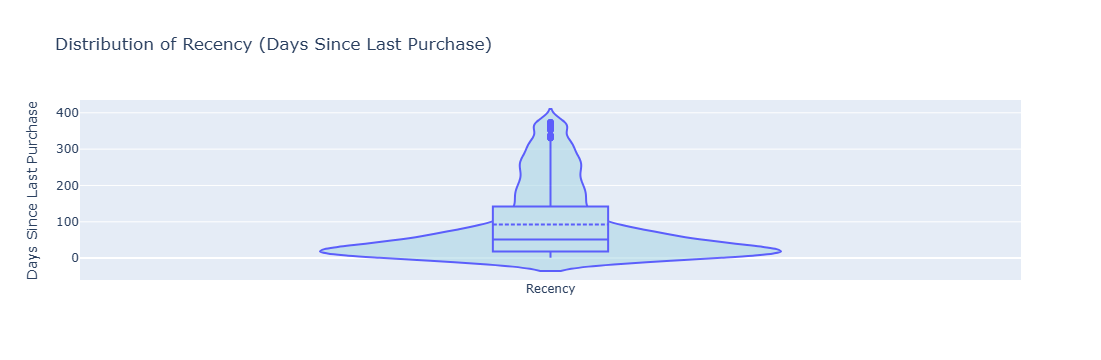

In [19]:
#Recency

import plotly.graph_objs as go
import plotly.offline as pyo

# Create the violin plot
violin = go.Violin(
    y=rfm_table['DaysSinceLastPurchase'],
    box_visible=True,  # Show the box plot inside the violin
    meanline_visible=True,  # Display the mean line
    line_color='blue',
    fillcolor='lightblue',
    opacity=0.6,
    name='Recency'
)

# Layout for the plot
layout = go.Layout(
    title="Distribution of Recency (Days Since Last Purchase)",
    yaxis=dict(title='Days Since Last Purchase'),  # Label for the y-axis
)

# Create the figure and plot it
fig = go.Figure(data=[violin], layout=layout)
pyo.iplot(fig)


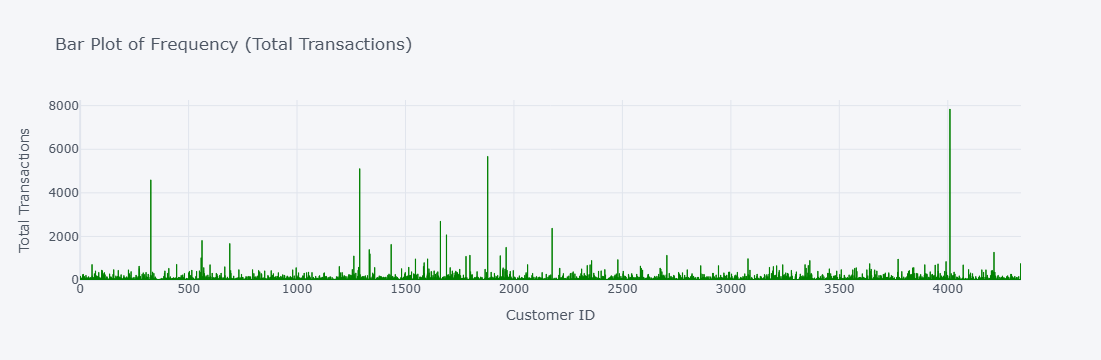

In [21]:
# Frequency (TotalTransactions)
rfm_table[['TotalTransactions']].iplot(
    kind='bar',
    title='Bar Plot of Frequency (Total Transactions)',
    xTitle='Customer ID',
    yTitle='Total Transactions',
    colors=['green']
)


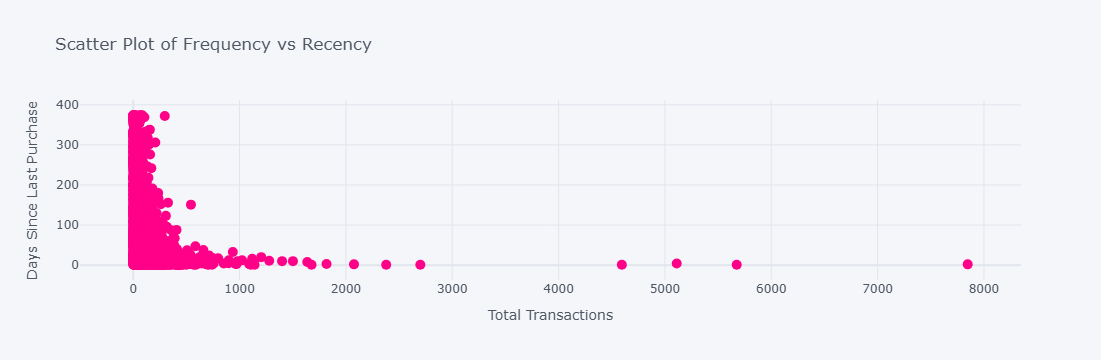

In [27]:
# Frequency vs Recency
rfm_table.iplot(
    kind='scatter', mode='markers',
    x='TotalTransactions', y='DaysSinceLastPurchase',
    title='Scatter Plot of Frequency vs Recency',
    xTitle='Total Transactions', yTitle='Days Since Last Purchase',
    size=10, color='pink'
)


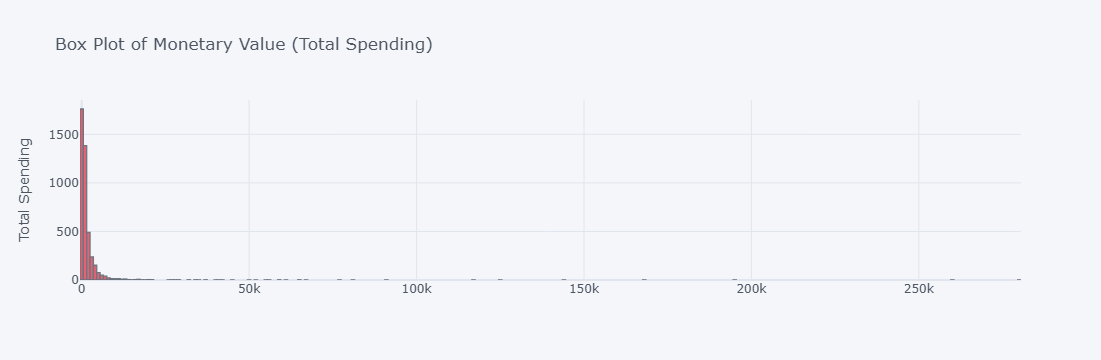

In [33]:
# Monetary (TotalSpending)
rfm_table[['TotalSpending']].iplot(
    kind='hist',
    title='Box Plot of Monetary Value (Total Spending)',
    yTitle='Total Spending',
    colors=['red']
)


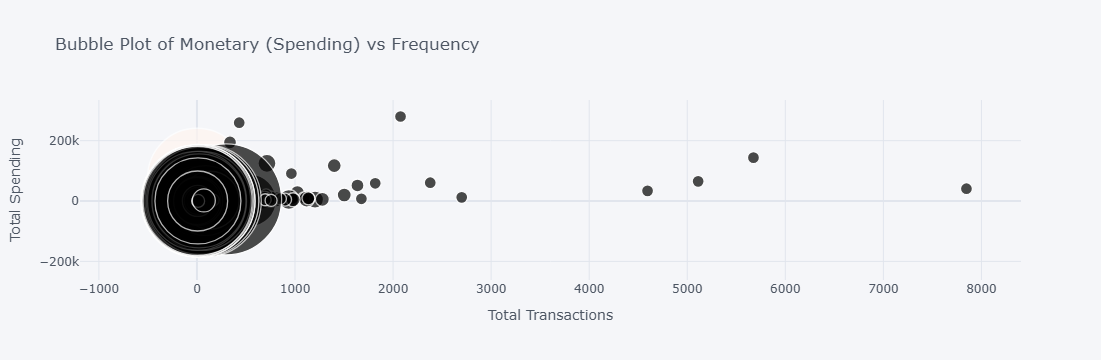

In [29]:
# Monetary (TotalSpending) vs Frequency (TotalTransactions)
rfm_table.iplot(
    kind='bubble', x='TotalTransactions', y='TotalSpending',
    size='DaysSinceLastPurchase', colorscale='reds',
    title='Bubble Plot of Monetary (Spending) vs Frequency',
    xTitle='Total Transactions', yTitle='Total Spending'
)


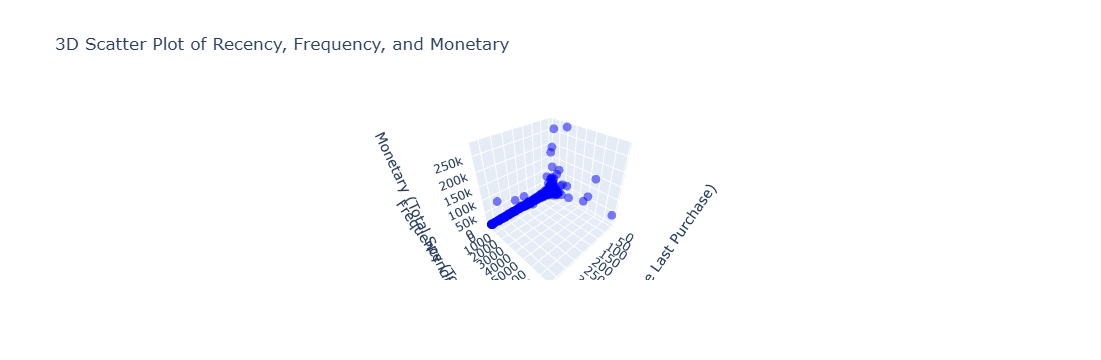

In [39]:
# Plot for Recency, Frequency, and Monetary
import plotly.graph_objs as go
import plotly.offline as pyo

# Create a 3D scatter plot for RFM analysis
scatter = go.Scatter3d(
    x=rfm_table['DaysSinceLastPurchase'],  # Recency
    y=rfm_table['TotalTransactions'],       # Frequency
    z=rfm_table['TotalSpending'],           # Monetary
    mode='markers',
    marker=dict(
        size=5,
        color='blue',  # Set a default color for the markers
        opacity=0.5
    ),
    text=rfm_table['CustomerID'],  # Optional: display Customer ID on hover
)

# Set up the layout for the 3D plot
layout = go.Layout(
    title='3D Scatter Plot of Recency, Frequency, and Monetary',
    scene=dict(
        xaxis=dict(title='Recency (Days Since Last Purchase)'),
        yaxis=dict(title='Frequency (Total Transactions)'),
        zaxis=dict(title='Monetary (Total Spending)')
    )
)

# Create the figure and plot it
fig = go.Figure(data=[scatter], layout=layout)
pyo.iplot(fig)



In [ ]:
#clustering

In [41]:
# Log transformation to reduce skewness in Frequency and Monetary
rfm_table['TotalSpending'] = np.log1p(rfm_table['TotalSpending'])
rfm_table['TotalTransactions'] = np.log1p(rfm_table['TotalTransactions'])

# Standardize the RFM variables
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm_table[['DaysSinceLastPurchase', 'TotalTransactions', 'TotalSpending']])

# Convert back to DataFrame
scaled_rfm = pd.DataFrame(scaled_rfm, columns=['RecencyScaled', 'FrequencyScaled', 'MonetaryScaled'])


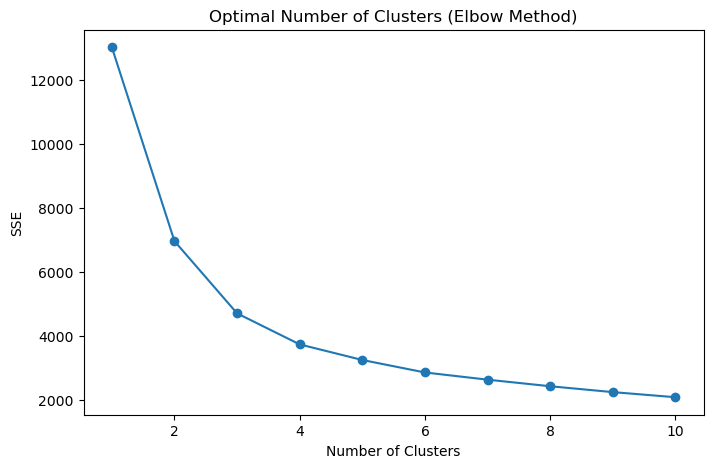

CustomerCluster
1    1590
0     940
2     925
3     883
Name: count, dtype: int64

In [43]:
# Use the Elbow Method to find the optimal number of clusters
sse_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_rfm)
    sse_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse_values, marker='o')
plt.title('Optimal Number of Clusters (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

# Choose k=4 based on the elbow method
kmeans_model = KMeans(n_clusters=4, random_state=42)
rfm_table['CustomerCluster'] = kmeans_model.fit_predict(scaled_rfm)

# View the cluster sizes
rfm_table['CustomerCluster'].value_counts()


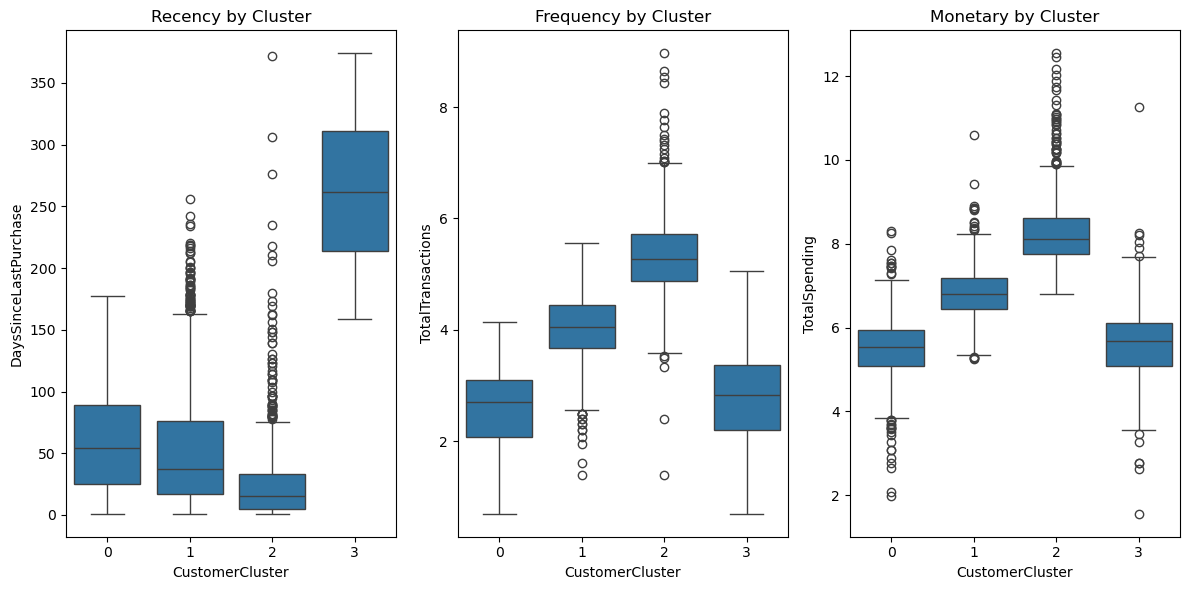

In [45]:
# Visualize the distributions of RFM features across different clusters
plt.figure(figsize=(12, 6))

# DaysSinceLastPurchase by cluster
plt.subplot(1, 3, 1)
sns.boxplot(x='CustomerCluster', y='DaysSinceLastPurchase', data=rfm_table)
plt.title('Recency by Cluster')

# TotalTransactions by cluster
plt.subplot(1, 3, 2)
sns.boxplot(x='CustomerCluster', y='TotalTransactions', data=rfm_table)
plt.title('Frequency by Cluster')

# TotalSpending by cluster
plt.subplot(1, 3, 3)
sns.boxplot(x='CustomerCluster', y='TotalSpending', data=rfm_table)
plt.title('Monetary by Cluster')

plt.tight_layout()
plt.show()


In [47]:
# Calculate the average RFM values per cluster
cluster_summary = rfm_table.groupby('CustomerCluster').agg({
    'DaysSinceLastPurchase': 'mean',
    'TotalTransactions': 'mean',
    'TotalSpending': 'mean'
}).reset_index()

# Display the cluster summary
cluster_summary


,CustomerCluster,DaysSinceLastPurchase,TotalTransactions,TotalSpending
0,0,62.582979,2.576885,5.489649
1,1,53.249686,4.041952,6.804075
2,2,26.145946,5.330663,8.283883
3,3,264.714609,2.754120,5.619269
